In [3]:
from datasets import load_dataset,load_from_disk
# \t is the tab character in Python
dataset_dict = load_from_disk('dataset_aug')
dataset_dict=dataset_dict.select_columns(['smi','logkOH•'])


In [6]:
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, Trainer, TrainingArguments,GPT2DoubleHeadsModel,GPT2PreTrainedModel,GPT2ForSequenceClassification
from datasets import load_dataset

# 定义标记器和模型配置
tokenizer = GPT2Tokenizer.from_pretrained(r"D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt100.json")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

'<|endoftext|>'

In [7]:
from torch import nn
from torch.nn.utils import prune

class GPT2LinearOutput(nn.Module):
    def __init__(self,n_block,drop,purn):
        super(GPT2LinearOutput, self).__init__()
        self.config=GPT2Config.from_pretrained('D:\system\桌面\lcm-code\pre_training\chem_gpt100')
        self.config.pad_token_id=tokenizer.pad_token_id
        self.config.num_attention_heads=4
        self.config.num_hidden_layers=n_block
        self.config.hidden_size=512
        self.gpt2 = GPT2Model(self.config)  #  使用预训练的GPT2模型
        self.linear = nn.Linear(self.config.hidden_size, 1)  # 输出维度为1的线性层
        for name, module in self.gpt2.named_modules():
            if isinstance(module, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
                module.p = drop
        for name, module in self.gpt2.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=purn)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        linear_output = self.linear(last_hidden_states)  # 只使用最后一个位置的隐藏状态
        return linear_output


In [8]:
tokenized_dataset = dataset_dict.map(
    lambda element: tokenizer(element['smi']),batched=True
)
def returnlength(example):
    return  {'length':len(example['input_ids'])-1}

tokenized_dataset=tokenized_dataset.map(returnlength)
tokenized_dataset=tokenized_dataset.select_columns(['input_ids','attention_mask','logkOH•','length'])
tokenized_dataset


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'logkOH•', 'length'],
        num_rows: 2122
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'logkOH•', 'length'],
        num_rows: 138
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'logkOH•', 'length'],
        num_rows: 138
    })
})

In [8]:
import torch
# from torch.utils.data import DataLoader, Dataset
# model=GPT2LinearOutput()


In [9]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_dataset.set_format("torch")



In [10]:
from torch.optim import AdamW
import torch.nn as nn
from transformers import get_scheduler

criterion = nn.MSELoss()
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True,collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_dataset["valid"], batch_size=69,collate_fn=data_collator)
test_dataloader=DataLoader(tokenized_dataset["test"], batch_size=69,collate_fn=data_collator)
num_train_epochs = 200
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

In [11]:
import pickle

# 读取 pickle 文件
with open('example-study.pkl', 'rb') as f:
    study = pickle.load(f)

# 现在你可以访问 study 对象中的信息，比如最优的超参数配置
print("最优参数配置:", study.best_params, study.best_value)


最优参数配置: {'num_blocks': 8, 'dropout': 0.2031915206133889, 'purns': 0.13211929362573221, 'lr': 0.00030663468933292816} 0.4131312966346741


In [12]:
from accelerate import Accelerator

accelerator = Accelerator()
model =GPT2LinearOutput(8,0.2,0.13)
# model.load_state_dict(torch.load('best_val0.model'))
train_dataloader, eval_dataloader,test_dataloader,model = accelerator.prepare(
    train_dataloader, eval_dataloader,test_dataloader,model
)
optimizer = AdamW(model.parameters(), lr=0.0003)
lr_scheduler = get_scheduler(
name="cosine",
optimizer=optimizer,
num_warmup_steps=num_training_steps//4,
num_training_steps=num_training_steps)

In [13]:
import torch
def caculate(loader,model):
    losses=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            labels = batch['logkOH•']
            batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(batch['input_ids'],batch['attention_mask']).squeeze()[torch.arange(0,len(batch['input_ids'])),batch['length']]
            loss = criterion(logits, labels)
            losses.append(loss.unsqueeze(dim=0))
    torch.cuda.empty_cache()
    return torch.sqrt(torch.mean(torch.cat(losses,dim=0))).cpu().numpy()

In [14]:
import numpy as np
from sklearn.metrics import r2_score
def caculater2(loader,model):
    y_true=[]
    y_pre=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            labels = batch['logkOH•']
            batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(batch['input_ids'],batch['attention_mask']).squeeze()[torch.arange(0,len(batch['input_ids'])),batch['length']]
            y_true.extend(labels.cpu().numpy())
            y_pre.extend(logits.cpu().numpy())
    return r2_score(y_true,y_pre)

In [21]:
model.load_state_dict(torch.load('best_val.model'))
model=accelerator.prepare(model)
caculater2(eval_dataloader,model)

0.6225388824135216

In [18]:
def compare(loader,model):
    y_true=[]
    y_pre=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            labels = batch['logkOH•']
            batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(batch['input_ids'],batch['attention_mask']).squeeze()[torch.arange(0,len(batch['input_ids'])),batch['length']]
            y_true.extend(labels.cpu().numpy())
            y_pre.extend(logits.cpu().numpy())
    return y_true,y_pre

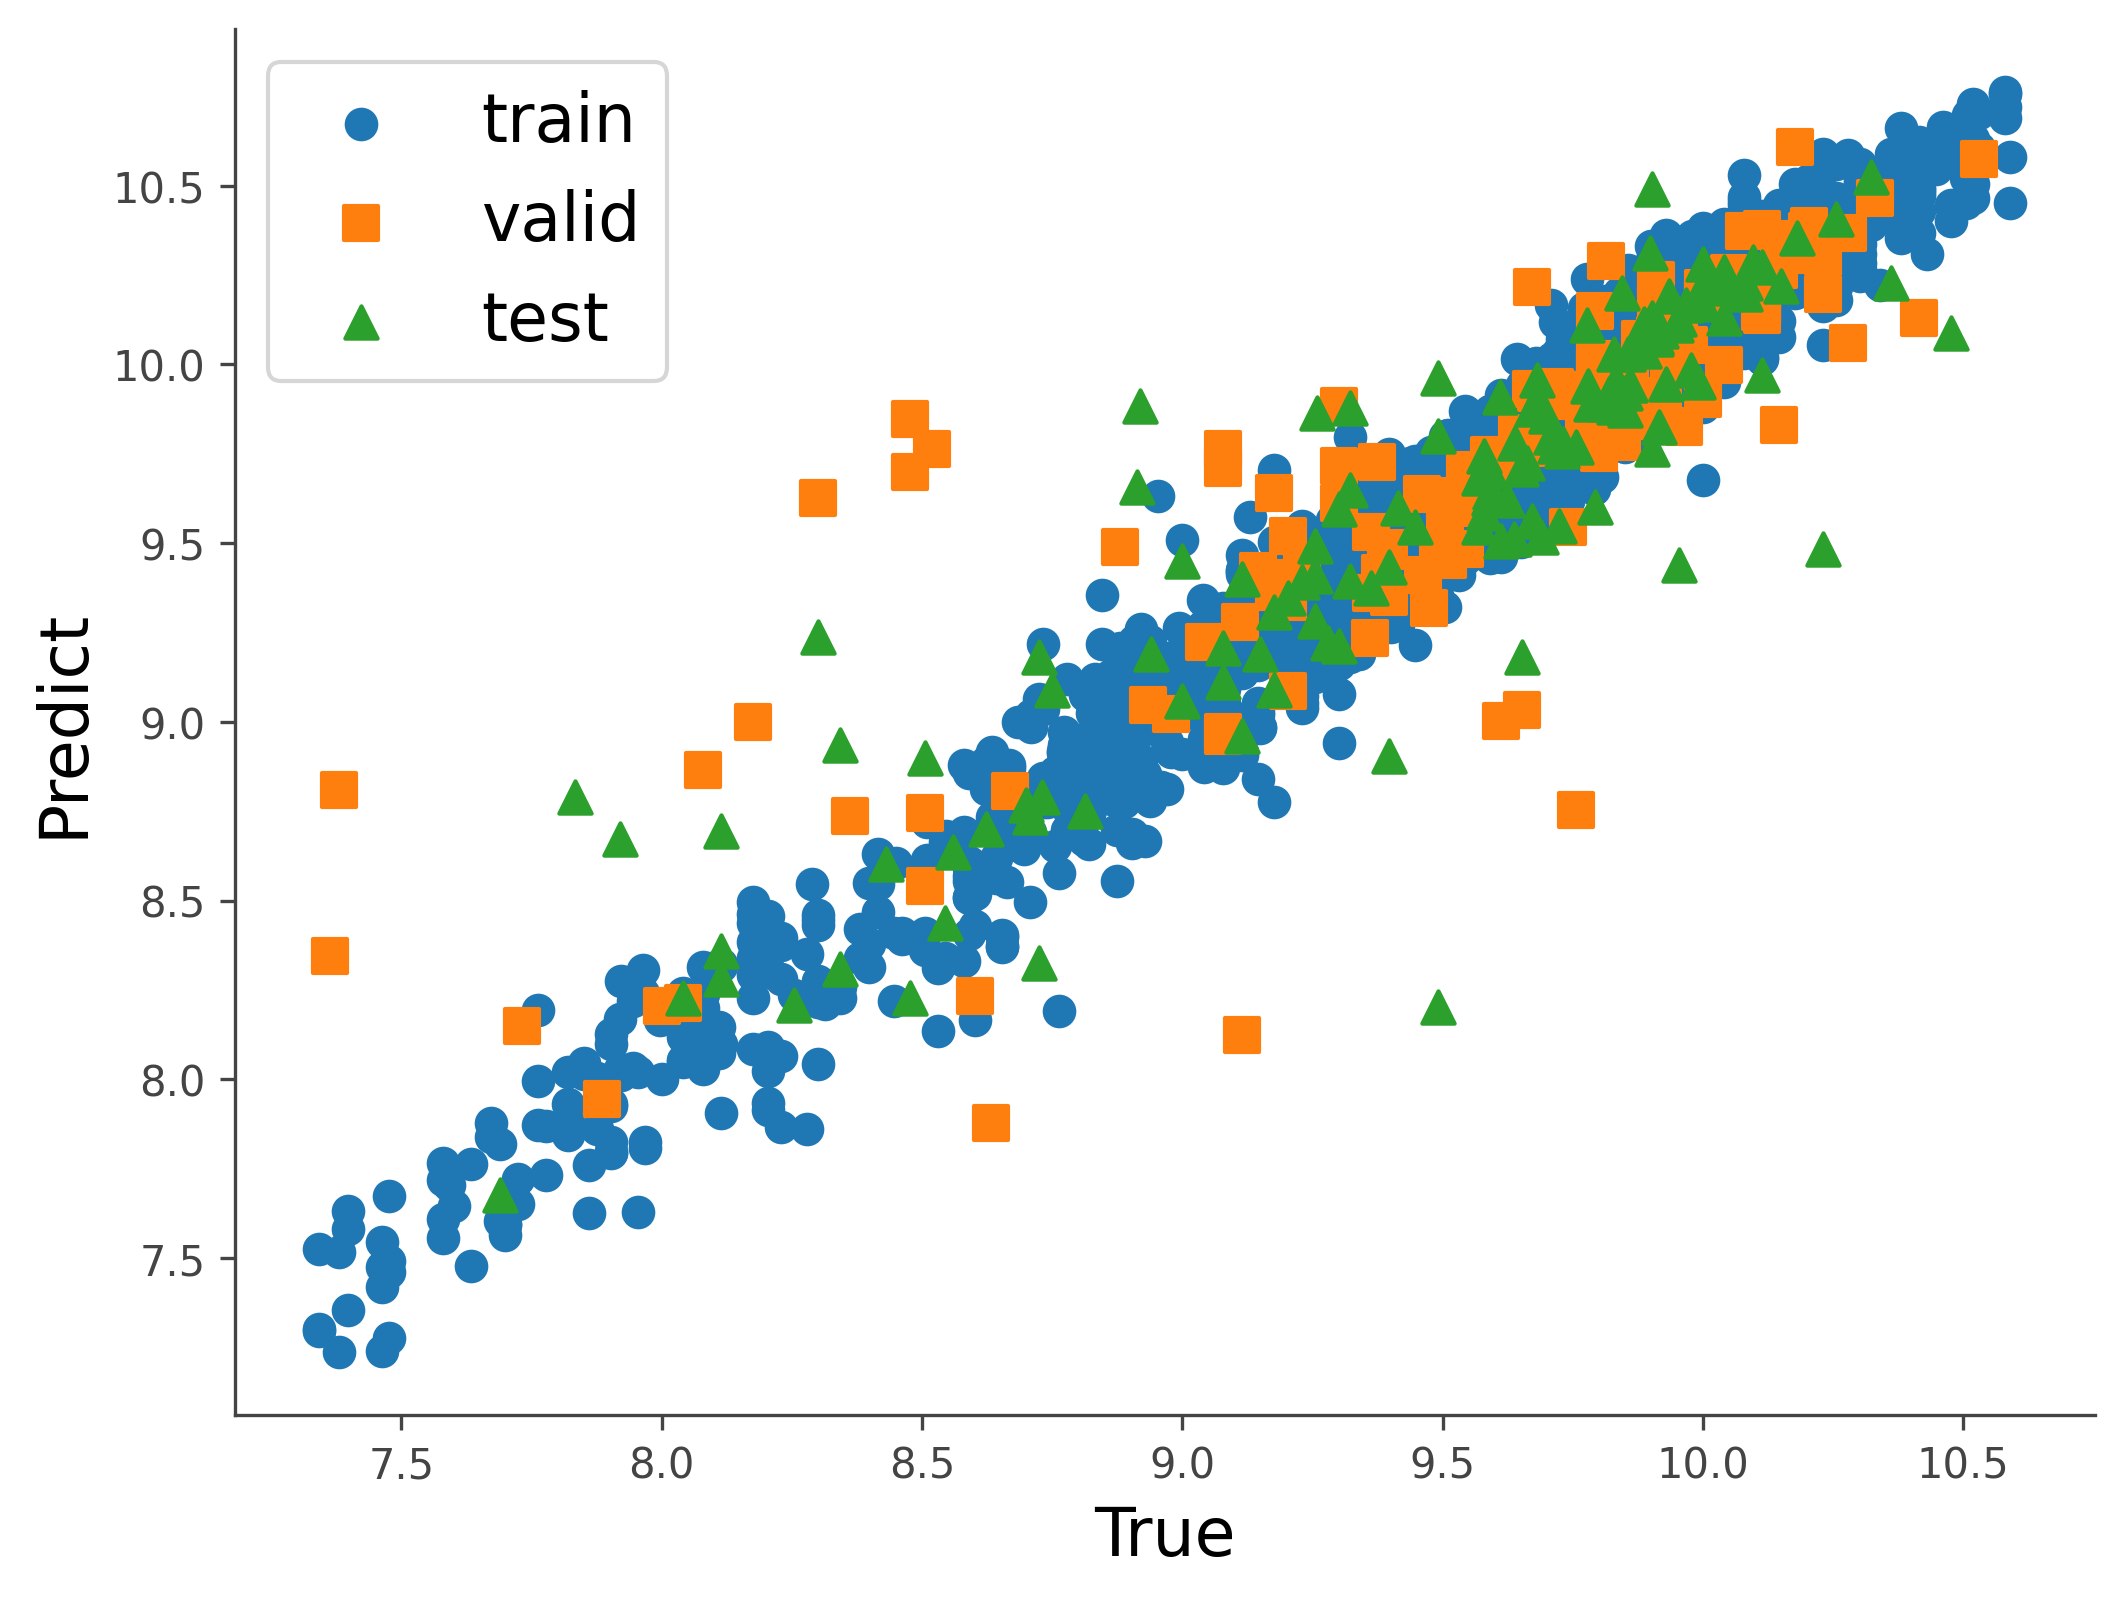

0.16679823
0.9169895514583891
0.38465807
0.6225388824135216
0.30358547
0.737983046840501


In [20]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt


from sklearn.metrics import mean_squared_error,r2_score

train_true,train_pre=compare(train_dataloader,model)
valid_true,valid_pre=compare(eval_dataloader,model)
test_true,test_pre=compare(test_dataloader,model)
plt.figure(figsize=(8,6),dpi=300)
plt.scatter(train_true,train_pre,label='train',color='#1f77b4', marker='o', s=50)
plt.scatter(valid_true,valid_pre,label='valid',color='#ff7f0e', marker='s', s=70)
plt.scatter(test_true,test_pre,label='test',color='#2ca02c', marker='^', s=60)
plt.legend(fontsize=16)
plt.xlabel('True',fontsize=16)
plt.ylabel('Predict',fontsize=16)


plt.gca().set_facecolor('white')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.gca().spines['left'].set_color('#444444')
plt.gca().spines['bottom'].set_color('#444444')
plt.gca().tick_params(axis='x', colors='#444444')
plt.gca().tick_params(axis='y', colors='#444444')
plt.show()

print(np.sqrt(mean_squared_error(train_true,train_pre)))
print(r2_score(train_true,train_pre))

print(np.sqrt(mean_squared_error(valid_true,valid_pre)))
print(r2_score(valid_true,valid_pre))

print(np.sqrt(mean_squared_error(test_true,test_pre)))
print(r2_score(test_true,test_pre))
